**Information Retrieval 1 2017-2018 Homework 1**
Team-members:
Julian Schoep (student-number: 10628126),
Nichita Diaconu (student-number: 11737980), 
Radu Sibechi (student-number: 11808527), 

##Theoretical Part



1  P(mth experiment gives significant result | m experiments lacking power to reject H0) = $1\alpha(1-\alpha)^m$ <br>
   P(at least one significant result | m experiments lacking power to reject H0) = $1 - P($no significant result$) = 1 - (1 - \alpha)^m$
   



2 Let's assume we have 5 documents, mainly A,B,C,D and E. Furthermore, let us assume that only 3 documents are of interest for the user with the following probabilities of being clicked: A = 48%, B = 48%, C= 4% while the others have 0%

Considering that the first algorithm (X) returns A,B,D,C,E while the second algorithm returns (Y) B,C,D,E,A. It is clearly visible that the first algorithm's results are much better than the second's algorithm results, because the first 2 results of X are the most interesting articles to the user, while A is at the bottom for Y.

* If X wins every coin toss then the interleaved list will look like: A, B, D, C, E with B,C being in team Y. 
* If Y wins every coin toss then the interleaved list will look like: B, A, C, D, E with B,C and E being in team Y 

From the examles above we can see that the interesting coin tosses are the first 2 ones as they contain all the documents that are going to be clicked by the user (and a document can only pertain to one team, unlike in balanced interleaving). As such we can ommit the third coin toss as it only assigns E (which has 0% probability of being clicked) to one of the two teams.

* If X wins first coin toss, X wins second coin toss => A,B,D,C with B,C being in team Y
* If X wins first coin toss, Y wins second coin toss => A,B,C,D with B,C being in team Y
* If Y wins first coin toss, Y wins second coin toss => B,A,C,D with B,C being in team Y
* If Y wins first coin toss, Y wins second coin toss => B,A,D,C with B,C being in team Y

As such, regardless of the coin toss, B and C will always be in team Y and as such Y will have a better chance of winning than X which only contains A which is of relevance, even though Y returned an obviously worse ranking


##Experimental Part

In [4]:
import itertools as it
import numpy as np
import abc
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import binom

###Step 1: Simulate Rankings of Relevance for E and P

In [5]:
def simulate_rankings(n=5000):
    '''
    if n is 0:
        returns all possible pairs of length 5 and 5
    
    if n > 0 of not specified (default is n=5000):
        returns n pairs randomly chosen from the set of all pairs
    '''
    R_M = ['N','R','HR'] # Relevance measures
    possible_rankings = list(it.product(R_M,repeat=5)) # Produces cartesian product of relevance measures, repeated 5 times
    
    ranking_pairs = it.permutations(possible_rankings,2)
    E_rankings = []
    P_rankings = []
    notated_pairs = []
    #print(len(list(ranking_pairs)))
    for pair in ranking_pairs:
        P_ranking, E_ranking = pair    
        d = {}
        d.update({'P':P_ranking})
        d.update({'E':E_ranking})
        notated_pairs.append(d)
    if not n: 
      samples = notated_pairs
    else:
      samples = np.random.choice(notated_pairs,n)
      
    P_rankings = []
    E_rankings = []
    
    for sample in samples:
        P_rankings.append(sample['P'])
        E_rankings.append(sample['E'])
    
    return (P_rankings, E_rankings)
  


###Step 2: Implement Evaluation Measures

In [6]:
# Helper function assigning a value to relevance tags.

def get_relevance(document_relevance):
    relevance = {
        'N' : 0,
        'R' : 1,
        'HR': 1,
    }
    return relevance[document_relevance]

In [7]:
#Step 2.A
def precision_k(result):
    # result is the tags (R, N, HR) of the top 5 documents returned by an algorithm
    # example result: ('R','R','N','R','HR')

    a = 0
    b = 0 # (precision at rank k) = a / b
  
    for d_r in result:
        relevance = get_relevance(d_r)
        a += relevance
        b += 1
  
    return a / b
  
  


In [8]:
#Step 2.B Normalized Discounted Cumulative Gain (nDCG)

def nDCG_k(result, k): 
    # For normalizing we need the best possible DCG result, which is
    # a high relevant (HR) at rank 1.
    perfect_DCG = (2**get_relevance('HR')-1)/np.log2(1 + 1)
    
    # result is the tags (R, N, HR) of the top 5 documents returned by an algorithm
    # example result: ('R','R','N','R','HR')
    # k is the particular rank at which the total accumulated gain is calculated
    nDCG_k =0 #nDCG at rank k
    for rank in range(k): # for all ranks up to and including k
        rank_k_result = result[rank] # returns the top k results
        rel = get_relevance(rank_k_result)
        nonlinear_gain = 2**rel
        discount = np.log2(1+rank+1)
        nDCG_k += ((nonlinear_gain -1)/discount)/perfect_DCG
    return nDCG_k
  



In [9]:
#Step 2.C Expected Reciprocal Rank

def ERR(result):
    # The expected reciprocal rank. The expectation over all ranks of the reciprocal rank
    
    # satisfaction of a document  = ( 2**relevance(decoument) - 1 ) / 2**max(relevance)
    # expectation of reciprocal rank = sum_over_all_ranks_r ( 1/rank_r * probability_of stopping_at_rank_r )
    # probability of stopping at rank_r = product_over_ranks_1_to_r_rr ( 1-probability_of_stopping_at_rank_rr ) * probability_of_stopping_at_rank_r
    sum = 0
    relevance_result = np.zeros(shape=(len(result)))
    for idx,res in enumerate(result):
        relevance = get_relevance(res)
        relevance_result[idx] = ( (2**relevance - 1 ) / 2 ** get_relevance('HR') )
        
    p = 1
    for r in range(len(result)):
        R = relevance_result[r]
        sum += p * R / (r+1)
        p = p * (1 - R)
    return sum


###Step 3: Calculate 𝛥measure

In [10]:
# DATASET FOR STEP 3:
P_rankings, E_rankings = simulate_rankings() # define global simulated P and E rankings


In [11]:
# Precision@k

def precision_measure_difference(P_rankings, E_rankings):
    # Precision at rank k
    delta_measure = 0
    resulting_P = []
    resulting_E = []
    
    for i in range(len(P_rankings)):
        p_measure = precision_k(P_rankings[i])
        e_measure = precision_k(E_rankings[i])
        if p_measure < e_measure:
            delta_measure += e_measure - p_measure
            resulting_P.append(P_rankings[i])
            resulting_E.append(E_rankings[i])
            
    return delta_measure, resulting_E, resulting_P
  
d_measure, precision_dataset_E, precision_dataset_P = precision_measure_difference(P_rankings, E_rankings)

precision_dataset = precision_dataset_E, precision_dataset_P


In [12]:
# Discounted Cumulative Gain
# DCG_5 is calculated


def DCG_measure_difference(P_rankings, E_rankings, DCG_rank):
  
  delta_measure = 0
  resulting_P = []
  resulting_E = []
  for i in range(len(P_rankings)):
      p_measure = nDCG_k(P_rankings[i],DCG_rank)
      e_measure = nDCG_k(E_rankings[i],DCG_rank)
      # print("P measure: {} E measure: {}".format(p_measure,e_measure))
      if p_measure < e_measure:
        delta_measure += e_measure - p_measure
        resulting_P.append(P_rankings[i])
        resulting_E.append(E_rankings[i])
      # print("Delta measure {}".format(delta_measure))
  return delta_measure, resulting_E, resulting_P

d_measure, DCG_dataset_E, DCG_dataset_P = DCG_measure_difference(P_rankings,E_rankings,5)

DCG_dataset = DCG_dataset_E, DCG_dataset_P


In [13]:
#ERR

def ERR_measure_difference(P_rankings, E_rankings):
  delta_measure = 0
  resulting_P = []
  resulting_E = []
  for i in range(len(P_rankings)):
      p_measure = ERR(P_rankings[i])
      e_measure = ERR(E_rankings[i])
      #print("P measure: {} E measure: {}".format(p_measure,e_measure))
      if p_measure < e_measure:
        delta_measure += e_measure - p_measure
        resulting_P.append(P_rankings[i])
        resulting_E.append(E_rankings[i])
      #print("Delta measure {}".format(delta_measure))
  return delta_measure,resulting_E, resulting_P
d_measure, ERR_dataset_E, ERR_dataset_P = ERR_measure_difference(P_rankings,E_rankings)
ERR_dataset = ERR_dataset_E, ERR_dataset_P

###Step 4: Implement Interleaving 

In [14]:
# global variable to generate unique id's
doc_id_counter = 0

class RankedDocument:
    doc_id = None # unique doc id
    source_ids = None # who added this document (usefull for interleaving)
    relevance_label = None

    def __init__(self, label, source_id=None, id=None):
        if id:
            self.doc_id = id
        else:
            self.doc_id = self.generate_id()
        self.relevance_label = label
        self.source_ids = []

        if source_id:
            self.source_ids.append(source_id)

    def generate_id(self):
        global doc_id_counter
        doc_id_counter += 1
        return doc_id_counter
    
    def get_id(self):
        return self.doc_id

    def add_source(self, source_id):
        self.source_ids.append(source_id)

    def get_source(self):
        if len(self.source_ids) == 1:
            return self.source_ids[0]
        else:
            return self.source_ids

    def get_relevance(self):
        return self.relevance_label

    def set_relevance(self, relevance_label):
        self.relevance_label = relevance_label

    def __repr__(self):
        return "" + str(self.doc_id) + "-source : " + ",".join(self.source_ids)


In [15]:
class InterleavingAlgorithm():
    @staticmethod
    def perform_interleaving(self):
        raise NotImplementedError
        
    '''
    Given a ranked document id, returns the index of the document in the haystack or false if it's not in the haystack
    '''
    @staticmethod
    def get_rd_index_from_list(ranked_document_id, haystack):
        for i in range(len(haystack)):
            if haystack[i].get_id() == ranked_document_id:
                return i

        return False

    '''
     Checks if the haystack contains all the needles or not.
    '''

    @staticmethod
    def not_fully_contained(needles, haystack):
        for needle in needles:
            if InterleavingAlgorithm.get_rd_index_from_list(needle.get_id(), haystack) is False:
                return True

        return False

    '''
    Returns the index of the first needle not contained in the haystack
    '''
    @staticmethod
    def index_top_result_not_contained(needles, haystack):
        for index, needle in enumerate(needles):
            if InterleavingAlgorithm.get_rd_index_from_list(needle.get_id(), haystack) is False:
                return index

        return False


class BalancedInterleaving(InterleavingAlgorithm):
    
    @staticmethod
    def perform_interleaving(A, B):
        interleaving = []
        k_a = 0
        k_b = 0

        a_first = np.random.randint(2)

        while k_a <= len(A) - 1 and k_b <= len(B) - 1:
            if (k_a < k_b) or (k_a == k_b and a_first == 1):
                if InterleavingAlgorithm.get_rd_index_from_list(A[k_a].get_id(), interleaving) is False:  # document has not been added yet
                    interleaving.append(A[k_a])
                else:  # document already exists in interleaving (added by B), add A as source as well
                    index = InterleavingAlgorithm.get_rd_index_from_list(A[k_a].get_id(), interleaving)
                    interleaving[index].add_source('P')
                k_a += 1
            else:
                if InterleavingAlgorithm.get_rd_index_from_list(B[k_b].get_id(), interleaving) is False:  # document has not been added yet
                    interleaving.append(B[k_b])
                else:  # document already exists in interleaving (added by A), add B as source as well
                    index = InterleavingAlgorithm.get_rd_index_from_list(B[k_b].get_id(), interleaving)
                    interleaving[index].add_source('E')
                k_b += 1
         # return the same amount of documents as original lists so user does not know they are interleaved
        return interleaving[0:len(A)]
        
  
class TeamDraftInterleaving(InterleavingAlgorithm):
    @staticmethod
    def perform_interleaving(A, B):
        interleaving = []
        team_A = []
        team_B = []

        while InterleavingAlgorithm.not_fully_contained(A, interleaving) and InterleavingAlgorithm.not_fully_contained(B, interleaving):
            a_first = np.random.randint(2)

            if len(team_A) < len(team_B) or (len(team_A) == len(team_B) and a_first):
                k = InterleavingAlgorithm.index_top_result_not_contained(A, interleaving)

                if k is not False:
                    interleaving.append(A[k])
                    team_A.append(A[k])
            else:
                k = InterleavingAlgorithm.index_top_result_not_contained(B, interleaving)

                if k is not False:
                    interleaving.append(B[k])
                    team_B.append(B[k])
        # return the same amount of documents as original lists so user does not know they are interleaved
        return interleaving[0:len(A)], team_A, team_B
    
#P = [RankedDocument('HR', 'P', 1), RankedDocument('HR', 'P'), RankedDocument('HR', 'P'), RankedDocument('HR', 'P'), RankedDocument('HR', 'P')]
#E = [RankedDocument('HR', 'E', 1), RankedDocument('HR', 'E'), RankedDocument('HR', 'E'), RankedDocument('HR', 'E'), RankedDocument('N', 'E')]

#TeamDraftInterleaving.perform_interleaving(P, E)
    

###Step 5: Implement User Clicks Simulation

In [16]:
import abc

class ClickModel(abc.ABC):
    #Implement the two models so that:
    
    @abc.abstractmethod
    def __init__(self):
        pass
    
    @abc.abstractmethod
    def learn_parameters(self, data):
        #(a) there is a method that learns the parameters of 
        #    the model given a set of training data
        pass
    
    @abc.abstractmethod
    def get_click_prob(self, relevacne_ranked_list):
        #(b) there is a method that predicts the click probability 
        #    given a ranked list of relevance labels
        pass
    
    @abc.abstractmethod
    def predict_clicks(self, probs):
        #(c) there is a method that decides - stochastically - whether 
        #    a document is clicked based on these probabilities
        pass

In [17]:
class RCM(ClickModel):
    #(a) the Random Click Model (RCM)
    
    def __init__(self):
        #rho is the parameter of RCM
        self.rho = None
      
    def learn_parameters(self, data):
        '''
        data:
        list of lists of queries and clicks 
        !!!! sorted by SessionID
        
        In the case of a Query:
        SessionID TimePassed TypeOfAction QueryID RegionID ListOfURLs of size 10
        
        In the case of a Click:
        SessionID TimePassed TypeOfAction URLID
        
        returns: 
        
        Computes the MLE of the rho parameter in the following way:
        nr. of clicks in all sessions / nr. of documents in all sessions
        '''
        
        documents = 0
        clicks = 0
        for action in data:
            if action[2] == 'Q':
                #Query
                SRP_size = len(action[5:])
                documents += SRP_size
            elif action[2] == 'C':
                #Click
                clicks += 1
            else:
                raise Exception('Actions should be either click C or query Q')
                
        self.rho = clicks/documents
    
    def get_click_prob(self, relevance_ranked_list):
        '''
        ranked_list is a list of relevance labels
        returns a list with same length as ranked lists containing
                for each document a probability of being clicked
        '''
        
        return [self.rho]*len(relevance_ranked_list)
      
    def predict_clicks(self, probs):
        '''
        probs is a list of probabilities
        returns a boolean list with same length as probs containing
                for each probability an outcome 
        '''
        samples = np.random.uniform(0,1,size=len(probs))
        return samples < self.rho

In [18]:
def get_yandex_actions():
    actions = []
    with open('YandexRelPredChallenge.txt') as fd:
        for line in fd:
            actions.append(line.strip().split('\t'))
    return actions
  
actions = get_yandex_actions()

In [19]:
class SDCM(ClickModel):
    #(a) the Simplified Dependent Click Model (SDCM)
    #    DCM with the assumption that the user is satisfied by the last clicked document,
    #    or they were not attracted by any document below it
    #    
    def __init__(self):
        #lambda and alfa are the parameters of the SDCM
        #lambda_r is learned and alfas are determined at runtime based on the relevance label of each link
        #as we have seen lambda being called both the continuation parameter and the satisfactoriness parameter,
        # we treat lambda_r as the satisfactoriness, and 1-lambda the continuation
        self.lambda_r = [None] * 10
        
        
    def learn_parameters(self, data):
        '''
        data:
        list of lists of queries and clicks 
        !!!! sorted by SessionID
        
        In the case of a Query:
        SessionID TimePassed TypeOfAction QueryID RegionID ListOfURLs of size 10
        
        In the case of a Click:
        SessionID TimePassed TypeOfAction URLID
        
        returns: 
        
        Computes the MLE of the lambda_r parameter in the following way:
        nr. of times r is the rank of the last clicked document / nr. of times a click at rank r is observed
        
        In order to see when a last click was made we need to define a session:
        The set of events between issuing a query and abandoning the search is called a session.
        Abandoning a search means not clicking anymore or issuing a new query.
        Unfortunately, the SessionID does not change when the user makes a new query so we have to treat
        issuing a new query as the moment when the session stops
        
        '''
        
        clicks_at_r = [0]*10
        clicks_last_at_r = [0]*10
        
        last_query = None
        last_click = None
        for idx in range(len(data)):
            if idx == 0:
                last_query = data[idx]
                continue
            action = data[idx]
            
            #get type of action
            action_type = action[2]
            
            if action_type == 'Q':
                #on query
                #stopping session and counting last click
                if last_click is not None:
                    #first get the index r of the last clicked document
                    url_id = last_click[3]
                    if url_id in last_query[5:]:
                        last_click_rank = last_query[5:].index(url_id)
                    else:
                        raise Exception('Invalid document id. Possibly not changed last query...')
                    clicks_last_at_r[last_click_rank] += 1
                
                #reset last_click and last_query
                last_click = None
                last_query = action
                #print('new query '+ str(action))
            elif action_type == 'C':
                #on click
                #count the click and save it as the new possible last click in current session
                #print('in click ' + str(action))
                #first get the index r of the clicked document
                url_id = action[3]
                if url_id in last_query[5:]:
                    click_rank = last_query[5:].index(url_id)
                else:
                    #print('appearently people can click things that don.t exist')
                    #there is a special case in the Yandex logs, where in the same SessionID a new query has been typed, but the user can still click
                    #on SERP from previous queries. We skiped these cases as we abandon a session when a new query is issued:
                    #e.g.:   67	429	Q	1494	0	13253	13252	3815	5319	13257	13251	13255	13254	13256	3816
                    #        67	472	Q	1494	0	13253	13252	3815	5319	13257	13251	13255	13254	13256	3816
                    #        67	509	C	13257
                    #        67	703	Q	2852	0	13253	25091	3815	671	4136	13256	25092	25094	25090	25093
                    #        67	757	C	3815
                    #        67	877	C	13251
                    #  we can see how DocumentID 13251 is not in the SERP of the last query, but the one before that
                    continue
                    #raise Exception('Invalid document id. Possibly not change last query')
                clicks_at_r[click_rank] += 1
                last_click = action
            else:
                raise Exception('Actions should be either click C or query Q')
            
        for i in range(10):
            if clicks_at_r[i] == 0:
                print('WEIRD')
            else:
                self.lambda_r[i] = clicks_last_at_r[i] / clicks_at_r[i]
                
    def get_click_prob(self, relevance_ranked_list):
        '''
        ranked_list is a list of relevance labels
        returns a list with same length as ranked lists containing
                for each document a probability of being clicked
                
        due to the fact that alphas should not be learned we compute attractiveness based on the relevance labels
        according to:
        DCG = 2 ** (relevance(document)-1) / 2 ** max(relevance)
        
        another attemp:
        according to: attractiveness should increase with relevance label and also increase as there are more and more unnatractive documents before it:
        DCG_r  = ( 2**(relevance(decoument)+(1-DCG_{r-1})) - 1 ) / 2 ** max(relevance)
        
        '''
        #P(C_u = 1) = alpha_uq * epsilon_r_u, where
        #epsilon_r+1 = epsilon_r * (alpha_u_rq*(1-lambda_r_u) + (1-alpha_u_rq))
        alphas = np.zeros(shape=(len(relevance_ranked_list)))
        irrelevants = 0
        for idx,relevance_label in enumerate(relevance_ranked_list):
            relevance = get_relevance(relevance_label)
            #relevance = (2**(relevance+(1-alphas[idx-1])) - 1 )/ ( 2 ** ( get_relevance('HR')+1) )
            relevance = (2**(relevance) - 1 )/ ( 2 ** ( get_relevance('HR')) )
            alphas[idx] = relevance
        epsilons = [0] * len(relevance_ranked_list)
        #first document is always examined
        epsilons[0] = 1
        for idx in range(1,len(epsilons),1):
            epsilons[idx] = epsilons[idx-1]*(alphas[idx-1]*(1-self.lambda_r[idx-1]) + (1-alphas[idx-1]))
            
        click_probs = [0] * len(relevance_ranked_list)
        for idx in range(len(click_probs)):
            click_probs[idx] = alphas[idx]*epsilons[idx]
        
        #print(self.lambda_r)
        #print('alphas: '+str(alphas))
        #print('epsilons: '+str(epsilons))
        #print('click_probs: '+str(click_probs))
        return click_probs
        
    def predict_clicks(self, probs):
        '''
        probs is a list of probabilities
        returns a boolean list with same length as probs containing
                for each probability an outcome 
        '''
        samples = np.random.uniform(0,1,size=len(probs))
        results = []
        for idx in range(len(samples)):
            if samples[idx] <= probs[idx]:
                results.append(1)
            else:
                results.append(0)
        return results
      

###Step 6: Simulate Interleaving Experiment

In [20]:
# ONLINE EVALUATION
list_id_ctr = 0
class Interleaved_ranking():
    # container of RankedDocument class
    
    list_id = 0
    ranked_document_list = [] # list of RankedDocument objects
    E_counter = 0
    P_counter = 0
    
    def __init__(self,interleaved_ranking):
        self.list_id = self.get_id()
        self.ranked_document_list = interleaved_ranking

    # Assigns an id to interleaved_ranking
    def get_id(self):
        global list_id_ctr
        list_id_ctr += 1
        return list_id_ctr
      
    # Returns a list of relevance tags of the ranking
    def get_relevance_tags(self):
        ranked_list = []
        for ranked_document in self.ranked_document_list:
            ranked_list.append(ranked_document.get_relevance())
        return ranked_list
      
    def __getitem__(self,key):
        return self.ranked_document_list[key]
    def __len__(self):
        return len(self.ranked_document_list)
    
    def __repr__(self):
        return "InterleavedRanking_{}".format(self.list_id)
    
def transform_to_rd(P_rankings, E_rankings):
    '''
    input: 2 lists strings, representing relevances from the relevance list ['N', 'R', 'HR'] 
    return: 2 respective lists of RankedDocument
    '''
    P_rd_rankings = []
    E_rd_rankings = []

    for i in range(len(P_rankings)):
        P_rd_rankings.append(RankedDocument(P_rankings[i], 'P'))
        E_rd_rankings.append(RankedDocument(E_rankings[i], 'E'))
    
    return P_rd_rankings, E_rd_rankings
      
    
def interleave_rankings(P_rankings, E_rankings, interleaving_algo):
    '''
    P_rankings: list string, representing relevances from the relevance list ['N', 'R', 'HR']
    E_rankings: list string, representing relevances from the relevance list ['N', 'R', 'HR']
    interleaving_algo: i
    '''
    interleaved_rankings = []
    for i in range(len(P_rankings)):
          P_rd_rankings, E_rd_rankings = transform_to_rd(P_rankings[i], E_rankings[i]) 
          interleaved_list,__,__ = interleaving_algo.perform_interleaving(
                                        P_rd_rankings, E_rd_rankings)
          interleaved_rankings.append(Interleaved_ranking(interleaved_list))
    return interleaved_rankings

  
def predict_click_positions(interleaved_ranking, click_model):
    # Get relevance tags of interleaved list
    relevance_tags = interleaved_ranking.get_relevance_tags()
    # Get click probabilities given relevance tags
    probs = click_model.get_click_prob(relevance_tags)
    # Predict simulated click positions given click probabilities
    click_positions = click_model.predict_clicks(probs)
    return click_positions

def get_wins(ranking, click_model):
    '''
    ranking: list of RankedDocument
    click model: ClickModel
    
    Returns: 3 bool:  E won, Tie, P won
    
    Applies the ClickModel, stochastically choosing which links it clicks for a given ranking
    Counts the documents of each algorithm, E, P and returns expressions
    '''
    E_counter = 0
    P_counter = 0
    # Get the positions at which the model predicts a user clicks
    predicted_click_positions = predict_click_positions(ranking, click_model)
    for r in range(len(ranking)):
        # If a user clicked on position r
        if predicted_click_positions[r]:
            if ranking[r].get_source() == 'E':
                # Clicked document belongs to E algorithm
                E_counter += 1
            else:
                P_counter += 1
    return E_counter > P_counter, E_counter == P_counter, E_counter < P_counter

def online_evaluation_dAB(dataset, interleaving_algo, click_model, N):
    # USING DELTA AB FROM PAPER
    E_rankings, P_rankings = dataset
    interleaved_rankings = interleave_rankings(P_rankings, E_rankings,
                                                interleaving_algo)
    
    # Train the click model on Yandex Click Log
    data =get_yandex_actions()
    click_model.learn_parameters(data)
    
    results = []
    
    for ranking in interleaved_rankings:
        E_wins = 0
        P_wins = 0
        ties = 0
        # Simulate clicks N times per interleaved ranking
        
        for run in range(N):
            win, draw, lose = get_wins(ranking, click_model)
            E_wins += win
            P_wins += lose
            ties += draw
            # Only consider runs where either E or P was better
        n = E_wins + P_wins+ties
        delta_AB = ((E_wins+(0.5*ties))/n)-0.5
        results.append(delta_AB)
    
    # Results here are per query, the proportion that E wins over P
    return results
  
def online_evaluation(dataset, interleaving_algo, click_model, N):
    '''
    dataset: list of 2 elements, E_rankings and P_rankings, each of which is a ranked list of documents
    interleaving algo: object of type InterleavingAlgorithm
    N: number of runs to run each ranking before deciding winner 
    
    return: list of proportions (floats) of that E won over P for each ranking
    
    For a given dataset, interleaving algorithm and a click model
    the function outputs the proportion of times E wins over P for each ranking
    given N simulations
    '''
    E_rankings, P_rankings = dataset
    interleaved_rankings = interleave_rankings(P_rankings, E_rankings,
                                                interleaving_algo)
    # Train the click model on Yandex Click Log
    data =get_yandex_actions()
    click_model.learn_parameters(data)
    
    results = []
    
    for ranking in interleaved_rankings:
        E_wins = 0
        P_wins = 0
        # Simulate clicks N times per interleaved ranking
        for run in range(N):
            win, draw, lose = get_wins(ranking, click_model)
            E_wins += win
            P_wins += lose
            # Only consider runs where either E or P was better
        n = E_wins + P_wins
        
        results.append(E_wins/(n+0.000001)) # Prevent division by zero.
        
    
    # Results here are per query, the proportion that E wins over P
    return results




In [21]:
# OFFLINE data


def get_precision_preferences(dataset):
    E_rankings, P_rankings = dataset
    P_measures = []
    E_measures = []
    for ranking in P_rankings:
        P_measures.append(precision_k(ranking))
    for ranking in E_rankings:
        E_measures.append(precision_k(ranking))
    return np.array(E_measures) - np.array(P_measures)
  
def get_nDCG_preferences(dataset, k):
    E_rankings, P_rankings = dataset
    P_measures = []
    E_measures = []
    for ranking in P_rankings:
        P_measures.append(nDCG_k(ranking,k))
    for ranking in E_rankings:
        E_measures.append(nDCG_k(ranking,k))
    return np.array(E_measures) - np.array(P_measures)
def get_ERR_preferences(dataset):
    
    E_rankings, P_rankings = dataset
    P_measures = []
    E_measures = []
    for ranking in P_rankings:
        P_measures.append(ERR(ranking))
    for ranking in E_rankings:
        E_measures.append(ERR(ranking))
    return np.array(E_measures) - np.array(P_measures)
  
  

    

In [22]:
# GET DATA

dataset = simulate_rankings(n=10000) # returns 10000 ranking pairs
rcm = RCM() # returns a Random Click Model
sdcm = SDCM() # returns a Simple Dependent Click Model

# Returns a Team Draft interleaver
tmi = TeamDraftInterleaving()

# Returns proportions of wins with Team Draft Interleaving given a random click model
online_tmi_rcm = online_evaluation(dataset,tmi,rcm, 100)
# Returns proportions of wins with Team Draft Interleaving given a simple dependent click model
online_tmi_sdcm = online_evaluation(dataset,tmi,sdcm, 100)

# Returns delta measures for precision evaluation
precision_preferences = get_precision_preferences(dataset)
# Returns delta measures for discounted cumulative gain evaluation at rank 5
NDCG_preferences = get_nDCG_preferences(dataset,5)
# Returns delta measures for expected reciprocal rank evaluation
ERR_preferences = get_ERR_preferences(dataset)


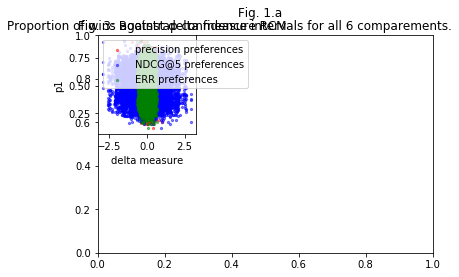

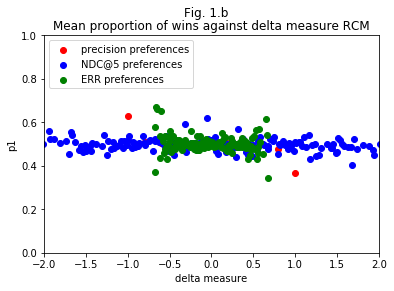

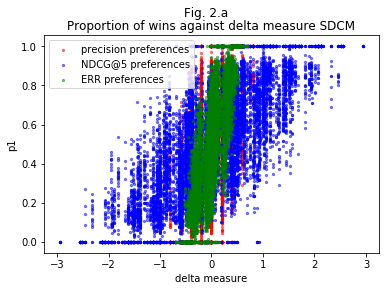

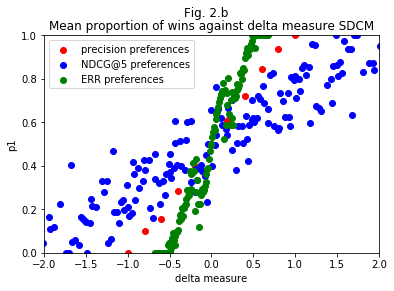

In [23]:
# PLOTS OF CORRELATION BETWEEN OFFLINE AND ONLINE EVALUATIONS

def get_y_means(x,y):
    # x and y are ordered. Couple the two values
    tuples = []
    for i in range(len(x)):
        tuples.append((x[i],y[i]))
    d = defaultdict(list)
    for t in tuples:
        xi,yi = t
        dict_key = int(xi*100)
        d[dict_key].append(yi)
    means = []
    x_means = []
    for key in d.keys():
        means.append(np.mean(d[key]))
        x_means.append(key/100)
    return x_means, means


y_data = online_tmi_rcm
plt.suptitle('Fig. 1.a')
plt.title("Proportion of wins against delta measure RCM")
plt.scatter(precision_preferences, y_data,c='r',s=5, alpha=0.5,label='precision preferences')
plt.scatter(NDCG_preferences, y_data , c='b', s=5, alpha=0.5,label='NDCG@5 preferences')
plt.scatter(ERR_preferences, y_data, c='g',s=5, alpha=0.5,label='ERR preferences')
plt.xlabel('delta measure')
plt.ylabel('p1')
plt.legend(loc='upper left')
plt.show()
  
plt.suptitle('Fig. 1.b')
plt.title("Mean proportion of wins against delta measure RCM")
x,y = get_y_means(precision_preferences,y_data)
plt.scatter(x,y,label='precision preferences',c='r')
x,y = get_y_means(NDCG_preferences,y_data)
plt.scatter(x,y,label='NDC@5 preferences',c='b')
x,y = get_y_means(ERR_preferences,y_data)
plt.scatter(x,y,label='ERR preferences',c='g')
plt.axis((-2,2,0,1))
plt.xlabel('delta measure')
plt.ylabel('p1')
plt.legend(loc='upper left')
plt.show()



plt.suptitle('Fig. 2.a')
y_data = online_tmi_sdcm
plt.title("Proportion of wins against delta measure SDCM")
plt.scatter(precision_preferences, y_data,c='r',s=5, alpha=0.5,label='precision preferences')
plt.scatter(NDCG_preferences, y_data , c='b', s=5, alpha=0.5,label='NDCG@5 preferences')
plt.scatter(ERR_preferences, y_data, c='g',s=5, alpha=0.5,label='ERR preferences')
plt.xlabel('delta measure')
plt.ylabel('p1')
plt.legend(loc='upper left')
plt.show()

plt.suptitle('Fig. 2.b')
plt.title("Mean proportion of wins against delta measure SDCM")
x,y = get_y_means(precision_preferences,y_data)
plt.scatter(x,y,label='precision preferences',c='r')
x,y = get_y_means(NDCG_preferences,y_data)
plt.scatter(x,y,label='NDCG@5 preferences',c='b')
x,y = get_y_means(ERR_preferences,y_data)
plt.scatter(x,y,label='ERR preferences',c='g')
plt.axis((-2,2,0,1))
plt.xlabel('delta measure')
plt.ylabel('p1')
plt.legend(loc='upper left')
plt.show()







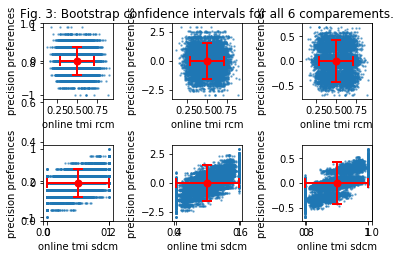

In [24]:
def bootstrap_confidence_interval_mean(data, n, alpha):
    # With the bootstrap confidence interval method we assume the sample mean to 
    # be the population mean, and we estimate the confidence interval of the mean
    # by performing k resamples (sampling w/o replacement) of size n, and 
    # calculating the resampled mean for each of these k resamples. Then we remove
    #  the top-alpha% and bottom-alpha% of the resulting resampled means and take
    #  the extremes as the 1-alpha % confidence interval.
    resamples = np.random.choice(data,size=n,replace=True)
    #for i in range(k): # take k samples
        #resample = np.random.choice(data, size=n, replace=True)
        #resamples.append(np.mean(resample))
    # Get the deviation from the sample mean for all resampled means
    #print(resample_means)
    #sample_deviations = resample_means - np.mean(data)
    # Sort
    sorted_samples = np.sort(resamples)
    lower_index = n*alpha-1
    #print(sorted_sample_deviations)
    higher_index = n*(1-alpha)-1
    #print(lower_index, higher_index)
    lower_delta = sorted_samples[int(lower_index)]
    upper_delta = sorted_samples[int(higher_index)]
    return np.mean(data),lower_delta, upper_delta

def plot(ax, x,y, labelx, labely):
    x_data = x
    ax.set_ylabel(labely)
    ax.set_xlabel(labelx)
    plt.scatter(x_data,y,s=2,alpha=0.5)
    x_mean, x_lower,x_upper = bootstrap_confidence_interval_mean(x_data,10000,0.05)
    xerr = [[x_mean-x_lower], [x_upper-x_mean]]
    y_mean, y_lower,y_upper = bootstrap_confidence_interval_mean(y,10000,0.05)
    yerr = [[y_mean-y_lower], [y_upper-y_mean]]
    plt.errorbar(x_mean,y_mean,yerr=yerr,xerr=xerr,
                 capthick=20,
                 fmt='o',
                 color='red',
                 capsize=5, elinewidth=2,markeredgewidth=2)


fig = plt.figure()
plt.title("Fig. 3: Bootstrap confidence intervals for all 6 comparements.")
ax1 = fig.add_subplot(231)    
plot(ax1, online_tmi_rcm, precision_preferences, 'online tmi rcm','precision preferences')
ax2 = fig.add_subplot(232)  
plot(ax2,online_tmi_rcm, NDCG_preferences, 'online tmi rcm','precision preferences')
ax3 = fig.add_subplot(233)  
plot(ax3,online_tmi_rcm, ERR_preferences, 'online tmi rcm','precision preferences')
ax4 = fig.add_subplot(234)  
plot(ax4,online_tmi_sdcm, precision_preferences, 'online tmi sdcm','precision preferences')
ax5 = fig.add_subplot(235)   
plot(ax5,online_tmi_sdcm, NDCG_preferences, 'online tmi sdcm','precision preferences')
ax6 = fig.add_subplot(236)  
plot(ax6,online_tmi_sdcm, ERR_preferences, 'online tmi sdcm','precision preferences')
fig.tight_layout()
plt.show()


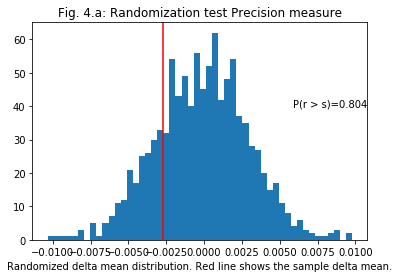

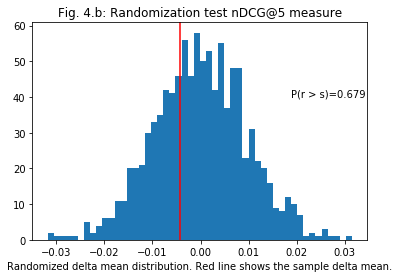

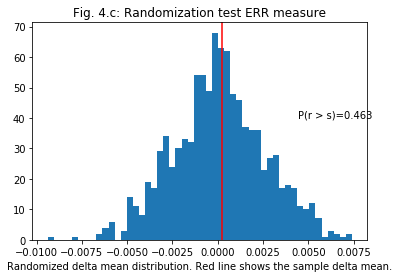

P(r>s) in this graph is the proportion of random delta measure means 
 that that are higher than the sample delta measure mean


In [25]:
# OFFLINE MEASURES RANDOMIZATION TEST
def get_precision_measures(dataset):
    E_rankings, P_rankings = dataset
    P_measures = []
    E_measures = []
    for ranking in P_rankings:
        P_measures.append(precision_k(ranking))
    for ranking in E_rankings:
        E_measures.append(precision_k(ranking))
    return E_measures,P_measures
  
def get_nDCG_measures(dataset, k):
    E_rankings, P_rankings = dataset
    P_measures = []
    E_measures = []
    for ranking in P_rankings:
        P_measures.append(nDCG_k(ranking,k))
    for ranking in E_rankings:
        E_measures.append(nDCG_k(ranking,k))
    return E_measures,P_measures
  
def get_ERR_measures(dataset):
    E_rankings, P_rankings = dataset
    P_measures = []
    E_measures = []
    for ranking in P_rankings:
        P_measures.append(ERR(ranking))
    for ranking in E_rankings:
        E_measures.append(ERR(ranking))
    return E_measures,P_measures
  
def randomization_test(E_measures, P_measures,N):
    E_mean = np.mean(E_measures)
    P_mean = np.mean(P_measures)
    mean_difference = E_mean - P_mean
    
    random_delta_means = []
    for i in range(N): #perform 1000 randomizations
        d1, d2 = randomly_mix(E_measures, P_measures)
        random_delta_mean = np.mean(d1) - np.mean(d2)
        random_delta_means.append(random_delta_mean)
    
    higher_mean_ctr = 0
    for mean in random_delta_means:
        if mean > mean_difference:
            higher_mean_ctr +=1
    # Proportion of random means being higher than actual mean:
    p = higher_mean_ctr / N
    return p, random_delta_means, mean_difference
    
def randomly_mix(dataset_1, dataset_2):
    full_data = dataset_1 + dataset_2
    n = len(dataset_1)    
    random_sets = np.random.choice(full_data, replace=False, size=(2,n))
    return random_sets

def plot_randomization_hist(p,random_delta_means, actual_delta_mean, title):
    plt.title(title)
    x = random_delta_means
    plt.hist(x, bins=50)
    plt.axvline(actual_delta_mean,color='r')
    plt.xlabel('Randomized delta mean distribution. Red line shows the sample delta mean.')
    text_str = "P(r > s)={}".format(p)
    plt.text(np.amax(x)*0.6,40,text_str)
    plt.show()
    
def plot_randomization_test(E_measures, P_measures,title):
    p, random_delta_means, actual_delta_mean = randomization_test(E_measures, P_measures,1000)
    plot_randomization_hist(p,random_delta_means, actual_delta_mean,title)
    
precision_E_measures, precision_P_measures = get_precision_measures(dataset)
plot_randomization_test(precision_E_measures,precision_P_measures,'Fig. 4.a: Randomization test Precision measure')

nDCG_E_measures, nDCG_P_measures = get_nDCG_measures(dataset,5)
plot_randomization_test(nDCG_E_measures,nDCG_P_measures,'Fig. 4.b: Randomization test nDCG@5 measure')

ERR_E_measures, ERR_P_measures = get_ERR_measures(dataset)
plot_randomization_test(ERR_E_measures,ERR_P_measures,'Fig. 4.c: Randomization test ERR measure')
print("P(r>s) in this graph is the proportion of random delta measure means \n that " 
       +"that are higher than the sample delta measure mean")

    

In [26]:
# ONLINE PROPORTIONS TEST
def get_global_proportion(dataset, interleaving_algo, click_model, N):
    '''
    dataset: list of 2 elements, E_rankings and P_rankings, each of which is a ranked list of documents
    interleaving algo: object of type InterleavingAlgorithm
    N: number of runs to run each ranking before deciding winner 
    
    return: list of proportions (floats) of that E won over P for each ranking
    
    For a given dataset, interleaving algorithm and a click model
    the function outputs the proportion of times E wins over P for each ranking
    given N simulations
    '''
    E_rankings, P_rankings = dataset
    interleaved_rankings = interleave_rankings(P_rankings, E_rankings,
                                                interleaving_algo)
    # Train the click model on Yandex Click Log
    data =get_yandex_actions()
    click_model.learn_parameters(data)
    
    results = []
    E_wins = 0
    P_wins = 0
    for ranking in interleaved_rankings:
        
        # Simulate clicks N times per interleaved ranking
        for run in range(N):
            win, draw, lose = get_wins(ranking, click_model)
            E_wins += win
            P_wins += lose
            # Only consider runs where either E or P was better
    n = E_wins + P_wins
        
    proportion = E_wins/n    
        
    
    # Results here are per query, the proportion that E wins over P
    return proportion, n


def proportions_test(p_hat, n, p_null):
    
    print("Sample proportion is {}".format(p_hat))
    z = (p_hat - p_null)/np.sqrt((p_null*(1-p_null)/n))
    print("Calculated Z value is {}".format(z))
    critical_value = 1.645 # for alpha=5%
    print("The critical value for alpha = 5% is {}".format(critical_value))
    if np.abs(z) > critical_value: # probability of finding the sample mean is small
        if z > 0:
          print("The sample proportion is significantly greater than the target proportion of {}".format(p_null))
        else:
          print("The sample proportion is significantly smaller than the target proportion of {}".format(p_null))
    else:
        print("There is no evidence to support whether the sample proportion is significantly" 
              + " different than the target proportion, since the calculated Z value does not" 
              + " lie in the rejection region.")
rcm_proportion, rcm_n = get_global_proportion(dataset,tmi,rcm, 100)
sdcm_proportion, sdcm_n = get_global_proportion(dataset,tmi,sdcm, 100)

proportions_test(rcm_proportion,rcm_n,0.5)
proportions_test(sdcm_proportion,sdcm_n,0.5)
    


Sample proportion is 0.5008699105718393
Calculated Z value is 1.1581891476681012
The critical value for alpha = 5% is 1.645
There is no evidence to support whether the sample proportion is significantly different than the target mean, since the calculated Z value does not lie in the rejection region.
Sample proportion is 0.5010910536938767
Calculated Z value is 1.6881446171480914
The critical value for alpha = 5% is 1.645
The sample proportion is significantly greater than the target proportion of 0.5


###Step 7: Results and Analysis

In order to find out whether the offline measures correlate with the online measures we:
* use the E and P pairs generated previously
* for each click model (Random Click Model (RCM) or Simple Dependent Click Model (SDCM)):
  * We plot a graph that contains 3 scatter plots such that for each offline evaluation measure ( precision@5, nDCG@5, ERR):
    * for each pair ranking pair (E, P):
      *  Plot the delta measure of the offline method against the proportional measure of the online method

The results are shown in figure 1 and figure 2.

Delta measure = the difference in measurement between two offline methods

Proportional measure = the proportion of time E outperforms P in an online experiment for the same ranking over N runs where we chose N arbitrarily to be 100

Due to the fact that these graphs look very crowded we cannot conclude the correlation between the measures. To better understand our values we divided the delta measures of the offline methods into buckets of size 0.01 and we plotted the average proportional value of the online method. This shows a more conclusive graph in terms of correlation between the online and the offline measures, while the previous graph tells us the variance from the mean is not negligible.

The experiment was run on the Random Click Model and on the Simple Dependent Click Model. The former was done in order to asses that our experiment were run correctly and a as a baseline. We can see that the points in the RCM case are evenly spread and a that their proportional average is close to 0.5 for each bucket of delta values. 
This makes sense because the random click model makes arbitrary choices in terms of which ranked document it clicks. Therefore with a large enough sample size there should be no preference for either algorithm E or P, given that the interleaving algorithm evenly distributes the ranked documents over the interleaved ranking. Finding almost all proportions for the random click model to be close to 0.5 shows that our interleaving algorithm does in fact do that.

The the error bars  in Fig. 3 show the result of the boostrap 95% confidence interval for each Click Model against each offline evaluation method pair. Again both confidence intervals are not above or below zero for offline or 0.5 for online evaluations, which demonstrate that there is not signficant preference for any evaluation for either algorithm E or P.

Next to looking at the correlation between the delta measure for offline evaluations and proportions for online evaluations, we looked at the significance of the findings of each evaluation separately. 
For the offline evaluations we performed a randomization test as illustrated in figure 4,which showed that none of the three offline measures showed a significant preference for either algorithm E or P (proportion of random sample means that was higher than the sample mean was at best 17%, which is much higher than the target of 5%.)
For online evaluations we performed a proportions test where we take for all the ranking pairs, and all the N(=100) runs per pair the number of times E wins divided by (E wins + P wins). This gives us a sample proportion for which we will test significance of alpha=5%. For both click models the Z-value calculated did not lie in the rejection region for $H_{0}: p=0.5$. Therefore for the online evaluation we conclude the same findings for the offline experiments; there is no significant preference for algorithm E or P.

Given all of our findings we conclude that the offline evaluations agree with the online evaluations.